# Peak method applied to NN
The script takes the ECG datasets and for every sample extracts relevant peaks which are then used to train the Neural Network

In [49]:
# Importing packages
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import keras
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import keras
import keras_tuner as kt
from keras.utils import to_categorical
from keras.layers import Dense, Convolution1D, Convolution2D, MaxPool1D, Flatten, Dropout, AveragePooling1D
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.utils import resample
import warnings
import os
warnings.filterwarnings('ignore')

In [50]:
# Load data from file and generate training, test and validation sets

DATA_SPLIT = 0.1
SEED = 12345

# Read files
train_df=pd.read_csv('src/mitbih_train.csv',header=None)
test_df=pd.read_csv('src/mitbih_test.csv',header=None)

In [51]:
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [52]:
train_df_x = train_df.iloc[:,:186].values
train_df_y = train_df[187]
set_train, set_valid, target_train, target_valid = train_test_split(train_df_x, train_df_y, test_size=DATA_SPLIT, random_state=SEED)
#train_df, valid_df = train_test_split(train_df, test_size=DATA_SPLIT, random_state=SEED)

set_test=test_df.iloc[:,:186].values
target_test=test_df[187]

y_train=to_categorical(target_train)
y_test=to_categorical(target_test)
y_valid=to_categorical(target_valid)

num_train = len(y_train)
num_test = len(y_test)
num_valid = len(y_valid)


### Separate signal data from category

target_train=train_df[187]
target_test=test_df[187]
target_valid=valid_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)
y_valid=to_categorical(target_valid)
set_train=train_df.iloc[:,:186].values
set_test=test_df.iloc[:,:186].values
set_valid=valid_df.iloc[:,:186].values


In [53]:
# Combine train and test data for preprocessing

v_data = np.append(set_train,set_test, 0)
v_data = np.append(v_data, set_valid, 0)
v_result = np.append(y_train, y_test, 0)
v_result = np.append(v_result, y_valid, 0)
print(len(v_data))

121892


In [54]:
# Define time array

v_time = np.arange(0, len(v_data[0]), 1, dtype=int)

In [55]:
# Calculate moving averages

# Window size for moving averages
LOWPASS_WINDOW = 3

v_data_lp = np.zeros_like(v_data)
#tmp_lowpass = np.zeros_like(v_data)

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

for i in range(0, len(v_data)):
    tmp_lowpass = moving_average(v_data[i], LOWPASS_WINDOW)
    v_data_lp[i] = np.pad(tmp_lowpass, (LOWPASS_WINDOW-1,0), 'constant', constant_values=(tmp_lowpass[0],0))

In [56]:
# Zeros array for x-axis

axis_x = np.zeros_like(v_data[0])

In [57]:
# Identify potential peaks
# Compare 3 signal samples S0, S1, S2
# Peak if:  S1>=S0 and S1>S2
#           S1<=S0 and S1<S2

DELTA_PEAK = 0.03      # Minimum signal amplitude from one peak to the next
DELTA_TIME = 25        # Maximum time after a peak in which DELTA_PEAK is considered (after this time peaks with any amplitude are considered)

v_peaks_data = np.zeros_like(v_data_lp)
v_peaks_time = np.zeros_like(v_data_lp)
#j = 0

for n in range(len(v_data_lp)):
    j = 0
    # Walk through all samples
    for i in range(1, len(v_data_lp[n])-1):
        # Identify peak
        if  ((v_data_lp[n][i] >= v_data_lp[n][i-1]) and (v_data_lp[n][i] > v_data_lp[n][i+1])) or \
            ((v_data_lp[n][i] <= v_data_lp[n][i-1]) and (v_data_lp[n][i] < v_data_lp[n][i+1])):
            # Check if peak value amd time
            if  (abs(v_data_lp[n][i] - v_peaks_data[n][j-1]) > DELTA_PEAK) or \
                (abs(v_time[i] - v_peaks_time[n][j-1]) > DELTA_TIME):
                #print("n:", str(n), " i:", str(i), " j:", str(j))
                v_peaks_data[n][j] = v_data_lp[n][i]
                v_peaks_time[n][j] = v_time[i]
                j += 1

#v_peaks_data[n] = v_peaks_data[n][v_peaks_time[n] != 0]
#v_peaks_time[n] = v_peaks_time[n][v_peaks_time[n] != 0]

In [58]:
# Delete samples with too many peaks

MAX_PEAK_NUM = 240       # Maximum peaks for each array

n_offset = 0
delta_num_train = 0
delta_num_test = 0
delta_num_valid = 0
del_peak_cat = [0,0,0,0,0]      # Log the category of each deleted peak

print('Samples before peak check: ' + str(len(v_peaks_data)))

for n in range(len(v_peaks_data)):
    index = n-n_offset
    if len(v_peaks_data[index][v_peaks_time[index] != 0]) > MAX_PEAK_NUM:
        # Delete from peak set
        v_peaks_data = np.delete(v_peaks_data, index, 0)
        v_peaks_time = np.delete(v_peaks_time, index, 0)
        # Delete from category set
        del_peak_cat = del_peak_cat + v_result[index]
        v_result = np.delete(v_result, index, 0)
        # Delete from samples set
        v_data_lp = np.delete(v_data_lp, index, 0)
        
        n_offset += 1
        if n < num_train:
            delta_num_train += 1
        elif n < num_train+num_test:
            delta_num_test += 1
        else:
            delta_num_valid += 1

num_train -= delta_num_train
num_test -= delta_num_test
num_valid -= delta_num_valid

print('Samples after peak check: ' + str(len(v_peaks_data)))
print('Categories: ')
print(del_peak_cat)

Samples before peak check: 121892
Samples after peak check: 121892
Categories: 
[0, 0, 0, 0, 0]


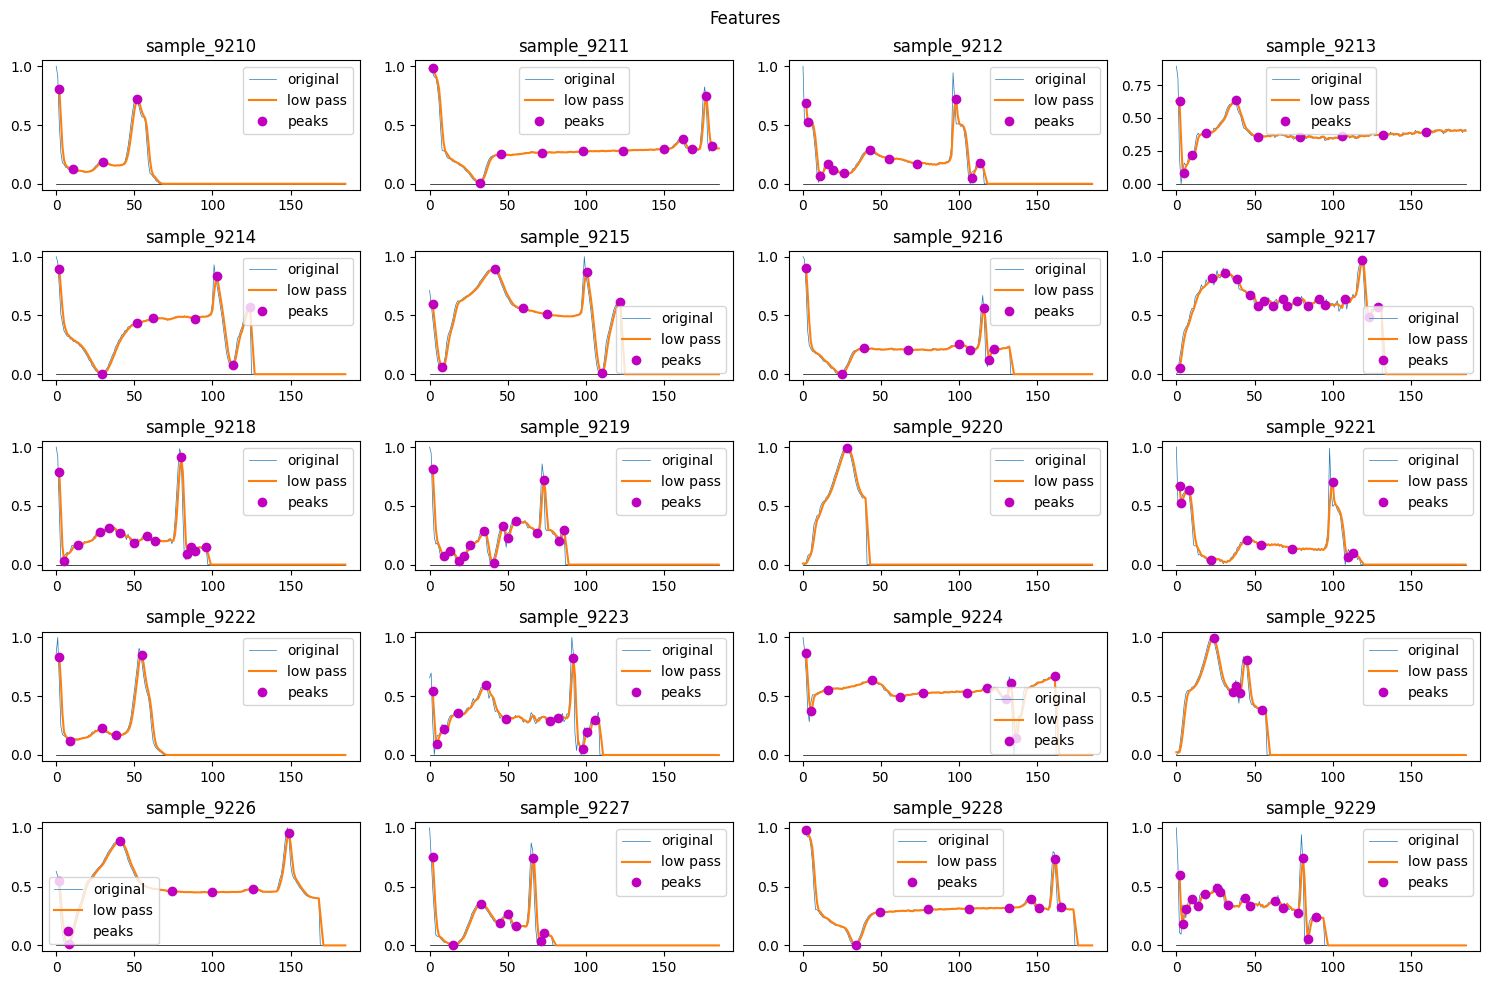

In [66]:
# Plot results
N_ROW = 5
N_COL = 4

fig, axs = plt.subplots(N_ROW, N_COL)
fig.set_size_inches(15, 2*N_ROW)
fig.suptitle("Features")
for i, ax in enumerate(axs.flatten()):
    ax.title.set_text('sample_'+str(i))
    ax.plot(axis_x, linewidth=0.5, color="black")
    ax.plot(v_data[i], linewidth=0.5, label="original")
    ax.plot(v_time, v_data_lp[i], label="low pass")

    v_peaks_data_plot = v_peaks_data[i][v_peaks_time[i] != 0]
    v_peaks_time_plot = v_peaks_time[i][v_peaks_time[i] != 0]
    ax.plot(v_peaks_time_plot, v_peaks_data_plot, 'mo', label="peaks")
    ax.legend()
plt.tight_layout()
plt.show()

In [60]:
# Create array combining peak amplitudes and peak times

# Find maximum length of peaks arrays
peak_length = np.zeros(len(v_peaks_data))
for i in range(len(v_peaks_data)):
    peak_length[i] = len(v_peaks_data[i][v_peaks_time[i] != 0])

max_length = int(np.max(peak_length))
peak_avg = np.ones(len(peak_length))*np.mean(peak_length)


# Define structure of arrays
NUM_PEAKS = 8
input_peaks = np.zeros((len(v_peaks_data),2*NUM_PEAKS))

# Fill strcuture with peaks data
# P0,dT0,P1,dT1,P2,dT2...,Pn,Tn  
# with Px: peak amplitude, Tx: delta time from previous peak
for n in range(len(v_peaks_data)):
    prev_time = 0
    tmp_data = v_peaks_data[n][v_peaks_time[n] != 0]
    tmp_time = v_peaks_time[n][v_peaks_time[n] != 0]
    # Calculate how many max and min peaks to consider
    if(len(tmp_data)>=NUM_PEAKS):
        n_max = math.ceil(NUM_PEAKS/2)
        n_min = NUM_PEAKS-n_max
    else:
        n_max = math.ceil(len(tmp_data)/2)
        n_min = len(tmp_data)-n_max
    # Select max and min indexes
    #print("tmp_data: " + str(tmp_data) +" n_min: " + str(n_min) +" n_max: " + str(n_max))
    i_max = np.argpartition(tmp_data, -n_max)[-n_max:]
    i_min = np.argpartition(tmp_data, n_min)[:n_min] 
    i_peaks = np.sort(np.append(i_max, i_min))
    #print(i_peaks)
    # Copy peaks amplitude and time
    for i in range(len(i_peaks)):
        if(i >= NUM_PEAKS):
            break
        # Copy peaks to structure
        input_peaks[n][2*i] = tmp_data[i]
        input_peaks[n][2*i+1] = tmp_time[i] - prev_time
        prev_time = tmp_time[i]

    #print(input_peaks[n])


<function matplotlib.pyplot.show(close=None, block=None)>

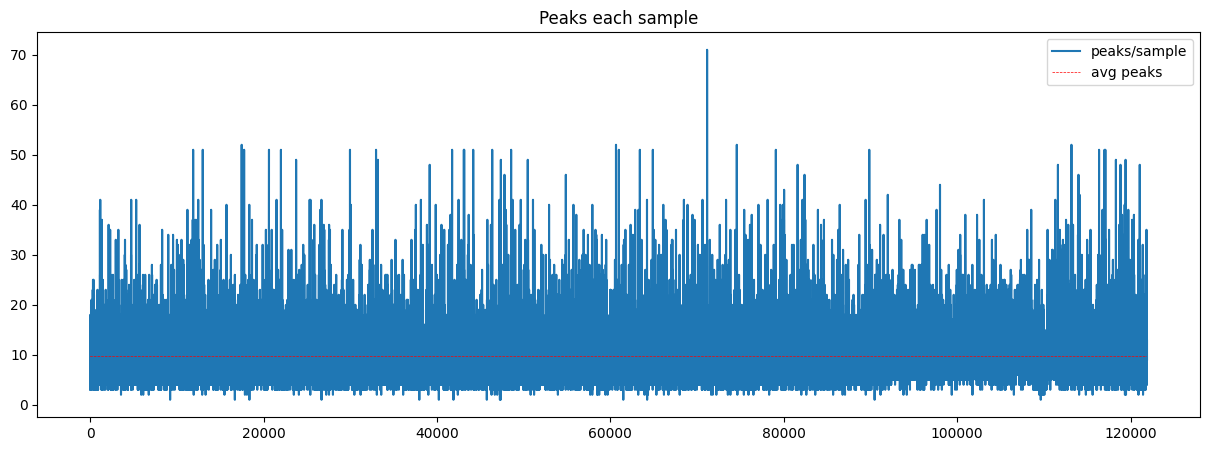

In [61]:
# Plot peaks data for all samples

plt.rcParams["figure.figsize"] = (15,5)
plt.title('Peaks each sample')
plt.plot(peak_length, label="peaks/sample")
plt.plot(peak_avg, 'r--', linewidth=0.5, label='avg peaks')
plt.legend()
plt.show

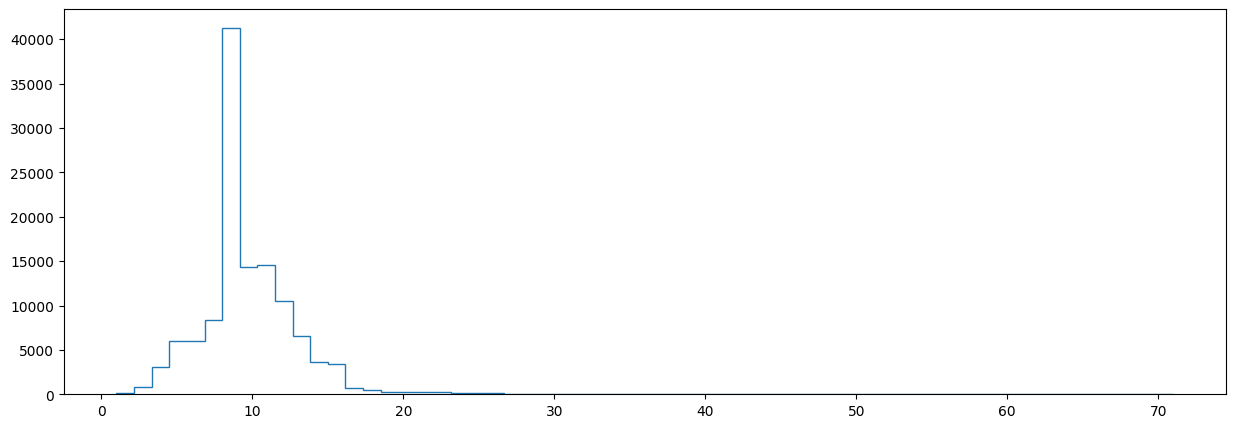

In [62]:
counts, bins = np.histogram(peak_length, bins=60)
plt.stairs(counts, bins)

In [63]:
# Plot samples with high number of peaks
N_ROW = 5
N_COL = 4
N_TOT = N_ROW*N_COL

max_index = np.argpartition(peak_length, -N_TOT)[-N_TOT:]

#fig, axs = plt.subplots(N_ROW, N_COL)
#fig.set_size_inches(15, 15)
#fig.suptitle("Features")
#for n, ax in enumerate(axs.flatten()):
#    i = max_index[n]
#    ax.title.set_text('sample_'+str(i))
#    ax.plot(axis_x, linewidth=0.5, color="black")
#    ax.plot(v_data_lp[i], label="low pass")

#    v_peaks_data_plot = v_peaks_data[i][v_peaks_time[i] != 0]
#    v_peaks_time_plot = v_peaks_time[i][v_peaks_time[i] != 0]
#    ax.plot(v_peaks_time_plot, v_peaks_data_plot, 'm.', label="peaks")
#    #ax.plot(peak_length[i]*np.ones_like(v_data_lp[i]), 'r--', linewidth=0.5)
#    ax.legend()
#plt.tight_layout()
#plt.show()

In [64]:
# Separate train and test data after processing

x_train = input_peaks[range(0, num_train, 1)]
x_test = input_peaks[range(num_train, num_train+num_test, 1)]
x_valid = input_peaks[range(num_train+num_test, num_train+num_test+num_valid, 1)]

y_train = v_result[range(0, num_train, 1)]
y_test = v_result[range(num_train, num_train+num_test, 1)]
y_valid = v_result[range(num_train+num_test, num_train+num_test+num_valid, 1)]

#print(v_result)
#print(x_train)
#y_train


In [65]:
# Network Architecture Search with Tensorflow

def build_model(hp):
  model = keras.Sequential()
  
  # Standard input layer
  model.add(keras.layers.Input(shape=((input_peaks[0].shape[0],1)), name='inputs_cnn'))

  # Tune whether to use convolutional layer
  if hp.Boolean("conv_1"):
    model.add(keras.layers.Convolution1D( filters=hp.Int("filters_1", min_value=1, max_value=5, step=1), 
                                          kernel_size=hp.Int("kernel_size_1", min_value=3, max_value=7, step=2),
                                          strides=1, padding="same", activation='relu'))
  
  if hp.Boolean("maxpool_1"):
    model.add(keras.layers.MaxPool1D(pool_size=hp.Int("pool_size_1", min_value=1, max_value=6, step=1)))

  if hp.Boolean("conv_2"):
    model.add(keras.layers.Convolution1D( filters=hp.Int("filters_2", min_value=1, max_value=5, step=1), 
                                          kernel_size=hp.Int("kernel_size_2", min_value=3, max_value=7, step=2),
                                          strides=1, padding="same", activation='relu'))
    
  if hp.Boolean("maxpool_2"):
    model.add(keras.layers.MaxPool1D(pool_size=hp.Int("pool_size_2", min_value=1, max_value=6, step=1)))
  
  # Flatten before dense layers
  model.add(keras.layers.Flatten())

  # Tune the number of units in the first Dense layer
  if hp.Boolean("dense_1"):
    model.add(keras.layers.Dense( units=hp.Int("units_1", min_value=5, max_value=20, step=1),
                                  activation="relu"))
    
  #if hp.Boolean("dense_2"):
  #  model.add(keras.layers.Dense( units=hp.Int("units_2", min_value=5, max_value=20, step=1),
  #                                activation="relu"))
  
  model.add(keras.layers.Dense(5, activation='softmax', name='main_output'))

  # Tune the learning rate 
  learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
  )

  return model

build_model(kt.HyperParameters())

tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=15,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

tuner.search(x_train, y_train, epochs=4, validation_data=(x_valid, y_valid))





Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
True              |True              |conv_1
False             |False             |maxpool_1
True              |True              |conv_2
True              |True              |maxpool_2
False             |False             |dense_1
0.006832          |0.006832          |lr

Epoch 1/4
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.1975 - loss: 1.6101 - val_accuracy: 0.1956 - val_loss: 1.6098
Epoch 2/4
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.2017 - loss: 1.6101 - val_accuracy: 0.1956 - val_loss: 1.6111
Epoch 3/4
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.1986 - loss: 1.6100 - val_accuracy: 0.2002 - val_loss: 1.6111
Epoch 4/4
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.1989 - loss: 1.6102 - val_accuracy: 0.2045 - val_loss: 1.6101
Epoch 1/4
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.4594 - loss: 1.5629 - val_accuracy: 0.5368 - val_loss: 1.1975
E

KeyboardInterrupt: 

In [ ]:
tuner.results_summary()

Results summary
Results in my_dir\helloworld
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 13 summary
Hyperparameters:
conv_1: False
maxpool_1: False
conv_2: False
maxpool_2: False
dense_1: True
lr: 0.0015463362595452633
filters_1: 3
kernel_size_1: 5
pool_size_1: 4
units_1: 16
pool_size_2: 1
filters_2: 5
kernel_size_2: 5
Score: 0.7249000072479248

Trial 11 summary
Hyperparameters:
conv_1: True
maxpool_1: False
conv_2: False
maxpool_2: False
dense_1: True
lr: 0.0023648890851369585
filters_1: 2
kernel_size_1: 3
pool_size_1: 5
units_1: 18
pool_size_2: 2
filters_2: 5
kernel_size_2: 7
Score: 0.705949991941452

Trial 02 summary
Hyperparameters:
conv_1: True
maxpool_1: True
conv_2: False
maxpool_2: True
dense_1: False
lr: 0.0019513235178244249
filters_1: 4
kernel_size_1: 7
pool_size_1: 3
units_1: 17
pool_size_2: 1
Score: 0.6685499846935272

Trial 12 summary
Hyperparameters:
conv_1: False
maxpool_1: False
conv_2: False
maxpool_2: False
dense_1: False
lr: 0.00229

In [ ]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

model = best_model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ main_output (Dense)             │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 357 (1.39 KB)

 Trainable params: 357 (1.39 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training parameters
EPOCH_NUM = 20
BATCH_SIZE = 32

# Train model
history=model.fit(x_train, y_train, epochs=EPOCH_NUM, batch_size=BATCH_SIZE, validation_data=(x_valid,y_valid))
#history=model.fit(x_train, y_train, epochs=EPOCH_NUM, batch_size=BATCH_SIZE, validation_data=(x_valid,y_valid), callbacks=[tensorboard_callback])


Epoch 1/20
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7304 - loss: 0.7717 - val_accuracy: 0.7193 - val_loss: 0.7628
Epoch 2/20
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7338 - loss: 0.7601 - val_accuracy: 0.7392 - val_loss: 0.7300
Epoch 3/20
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7405 - loss: 0.7336 - val_accuracy: 0.7381 - val_loss: 0.7265
Epoch 4/20
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7458 - loss: 0.7255 - val_accuracy: 0.7494 - val_loss: 0.7228
Epoch 5/20
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7469 - loss: 0.7174 - val_accuracy: 0.7400 - val_loss: 0.7233
Epoch 6/20
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7528 - loss: 0.7026 - val_accuracy: 0.7484 - val_loss: 0.7088
Epoch 7/20
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7538 - loss: 0.7000 - val_accuracy: 0.7587 - val_loss: 0.6730
Epoch 8/20
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7616 - loss: 0.6740 - 

In [ ]:
y_prediction = model.predict(x_test)
y_prediction = np.argmax (y_prediction, axis = 1)
y_test=np.argmax(y_test, axis=1)

# Create confusion matrix and normalize it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize='pred')
classes = [0,1,2,3,4]
result_norm = np.around(result, 4)
mat_result = pd.DataFrame(result_norm,
                     index = classes, 
                     columns = classes)

total_pred = np.trace(result) / 5

print('Confusion matrix')
print(mat_result)
print()
print('Average accuracy')
print(total_pred)

685/685 ━━━━━━━━━━━━━━━━━━━━ 1s 881us/step
Confusion matrix
        0       1       2       3       4
0  0.9726  0.8784  0.5165  0.8594  0.1987
1  0.0059  0.0989  0.0056  0.0106  0.0022
2  0.0126  0.0202  0.4407  0.0624  0.0293
3  0.0015  0.0004  0.0013  0.0595  0.0005
4  0.0074  0.0020  0.0359  0.0081  0.7693

Average accuracy
0.46819102781556127


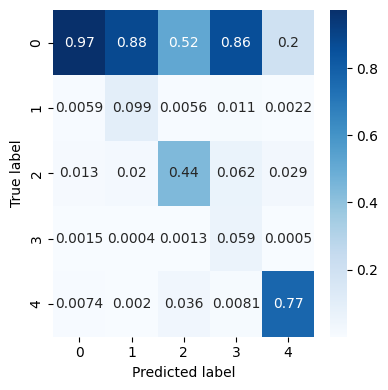

In [ ]:
figure = plt.figure(figsize=(4, 4))
sns.heatmap(mat_result, annot=True,cmap=plt.cm.Blues)
#plt.title(model_name)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
#plt.savefig(log_dir + '/' + model_name + '.png', pad_inches=0.1)
plt.show()